In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import MissingIndicator
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from catboost import CatBoostClassifier

In [2]:
train = pd.read_csv("data/train.csv", index_col=0)
test = pd.read_csv("data/test.csv", index_col=0)  # does not contain targets

#Gender
##train_no_gender = train.copy().drop(columns="Gender")
##test_no_gedner = test.copy().drop(columns="Gender")

train_no_gender = train.copy().dropna(subset=["Gender"])
test_no_gender = test.copy().dropna(subset=["Gender"])

le = LabelEncoder()
train_no_gender.Gender = le.fit_transform(train_no_gender.Gender)
test_no_gender.Gender = le.transform(test_no_gender.Gender)


# Married
train_no_nan_married = train_no_gender.copy().dropna(axis=0, subset=["Married"])
train_no_nan_married = pd.get_dummies(train_no_nan_married, columns=["Married"], drop_first=True)

test_no_nan_married = test_no_gender.copy().dropna(axis=0, subset=["Married"])
test_no_nan_married = pd.get_dummies(test_no_nan_married, columns=["Married"], drop_first=True)

# Dependents
train_dependent_only_int = train_no_nan_married.copy().replace("3+", 3)
for number in range(0, 3):
    train_dependent_only_int = train_dependent_only_int.replace(f"{number}", number)

train_dependents_no_nan = train_dependent_only_int.copy()

test_dependent_only_int = test_no_nan_married.copy().replace("3+", 3)
for number in range(0, 3):
    train_dependent_only_int = test_dependent_only_int.replace(f"{number}", number)

test_dependents_no_nan = test_dependent_only_int.copy()

# Education
train_education_dummies = pd.get_dummies(train_dependents_no_nan.copy(), columns=["Education"], drop_first=True)

test_education_dummies = pd.get_dummies(test_dependents_no_nan.copy(), columns=["Education"], drop_first=True)

# Self_Employed
train_self_employed_encoded = train_education_dummies.copy()

train_self_employed_encoded.Self_Employed = train_self_employed_encoded.Self_Employed.replace(["No", "Yes"], [0, 1])

test_self_employed_encoded = test_education_dummies.copy()

test_self_employed_encoded.Self_Employed = test_self_employed_encoded.Self_Employed.replace(["No", "Yes"], [0, 1]) 

# Loan_Amount_Term
si = SimpleImputer(strategy="median")

train_imputed_loan_amount_term = train_self_employed_encoded.copy()
train_imputed_loan_amount_term.Loan_Amount_Term = si.fit_transform(train_imputed_loan_amount_term.Loan_Amount_Term.values.reshape(-1, 1))


test_imputed_loan_amount_term = test_self_employed_encoded.copy()
test_imputed_loan_amount_term.Loan_Amount_Term = si.transform(test_imputed_loan_amount_term.Loan_Amount_Term.values.reshape(-1, 1))
# Credit_History



# Property_Area and Loan_Status
train_property_area_n_target = pd.get_dummies(train_imputed_loan_amount_term.copy(), columns=["Property_Area", "Loan_Status"], drop_first=True)

test_property_area_n_target = pd.get_dummies(test_imputed_loan_amount_term.copy(), columns=["Property_Area"], drop_first=True)

# Loan amount
train_LoanAmount_itterative_imputer = train_property_area_n_target.copy()

X = train_LoanAmount_itterative_imputer.iloc[:, :-1]
y = train_LoanAmount_itterative_imputer.iloc[:, -1]

imp_mean = IterativeImputer(random_state=0)
X = imp_mean.fit_transform(X)

X = pd.DataFrame(X, columns=train_LoanAmount_itterative_imputer.iloc[:, :-1].columns)

test_LoanAmount_itterative_imputer = test_property_area_n_target.copy()

X_test = test_LoanAmount_itterative_imputer
X_test = imp_mean.transform(X_test)
X_test = pd.DataFrame(X_test, columns=test_LoanAmount_itterative_imputer.columns)

## Train our model on the Train data, then make predictions on our Test data

In [3]:
model = CatBoostClassifier(depth=6, l2_leaf_reg=1, learning_rate=0.1, iterations=16)  # model for Streamlit
model.fit(X.iloc[:, [0, 3, 4, 5, 6, 7, 10]], y)  # The columns for our model

0:	learn: 0.6595022	total: 153ms	remaining: 2.29s
1:	learn: 0.6300864	total: 154ms	remaining: 1.08s
2:	learn: 0.6068011	total: 156ms	remaining: 675ms
3:	learn: 0.5848395	total: 157ms	remaining: 472ms
4:	learn: 0.5668290	total: 159ms	remaining: 349ms
5:	learn: 0.5496625	total: 160ms	remaining: 267ms
6:	learn: 0.5339164	total: 162ms	remaining: 208ms
7:	learn: 0.5216715	total: 163ms	remaining: 163ms
8:	learn: 0.5106223	total: 165ms	remaining: 128ms
9:	learn: 0.5018110	total: 166ms	remaining: 99.9ms
10:	learn: 0.4938930	total: 168ms	remaining: 76.4ms
11:	learn: 0.4869199	total: 169ms	remaining: 56.5ms
12:	learn: 0.4812908	total: 171ms	remaining: 39.5ms
13:	learn: 0.4757017	total: 173ms	remaining: 24.7ms
14:	learn: 0.4708437	total: 174ms	remaining: 11.6ms
15:	learn: 0.4651778	total: 176ms	remaining: 0us


In [4]:
predictions = model.predict(X_test.iloc[:, [0, 3, 4, 5, 6, 7, 10]])
predictions = pd.Series(predictions, dtype=int)

test_data = X_test.copy()
test_data["Loan_Status"] = predictions

In [5]:
test_data

,Gender,Dependents,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Married_Yes,Education_Not Graduate,Property_Area_Semiurban,Property_Area_Urban,Loan_Status
0,1.0,0.0,0.0,5720.0,0.0,110.0,360.0,1.000000,1.0,0.0,0.0,1.0,1
1,1.0,1.0,0.0,3076.0,1500.0,126.0,360.0,1.000000,1.0,0.0,0.0,1.0,1
2,1.0,2.0,0.0,5000.0,1800.0,208.0,360.0,1.000000,1.0,0.0,0.0,1.0,1
3,1.0,2.0,0.0,2340.0,2546.0,100.0,360.0,0.848999,1.0,0.0,0.0,1.0,1
4,1.0,0.0,0.0,3276.0,0.0,78.0,360.0,1.000000,0.0,1.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,1.0,3.0,1.0,4009.0,1777.0,113.0,360.0,1.000000,1.0,1.0,0.0,1.0,1
352,1.0,0.0,0.0,4158.0,709.0,115.0,360.0,1.000000,1.0,0.0,0.0,1.0,1
353,1.0,0.0,0.0,3250.0,1993.0,126.0,360.0,0.847238,0.0,0.0,1.0,0.0,1
354,1.0,0.0,0.0,5000.0,2393.0,158.0,360.0,1.000000,1.0,0.0,0.0,0.0,1


## Summary and Visualization

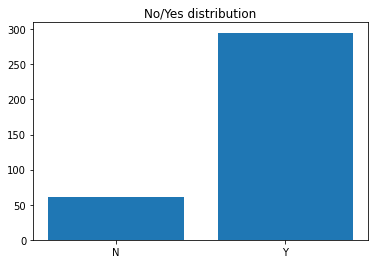

In [7]:
amount_loan = np.unique(predictions.replace([0, 1], ["N", "Y"]), return_counts=True)
plt.bar(x=amount_loan[0], height=amount_loan[1])
plt.title("No/Yes distribution")
plt.savefig("img/predicted_count")
plt.show()

In [9]:
np.unique(y, return_counts=True)

(array([0, 1], dtype=uint8), array([187, 411], dtype=int64))

In [158]:
test_data.Loan_Status.value_counts()  # 1=Y, 0=N

1    295
0     61
Name: Loan_Status, dtype: int64

Majoriteten av de som søker om lån, får det.

#### La oss se litt nærmere på hvilke "features" som påvirker prediskjonene våre mest:

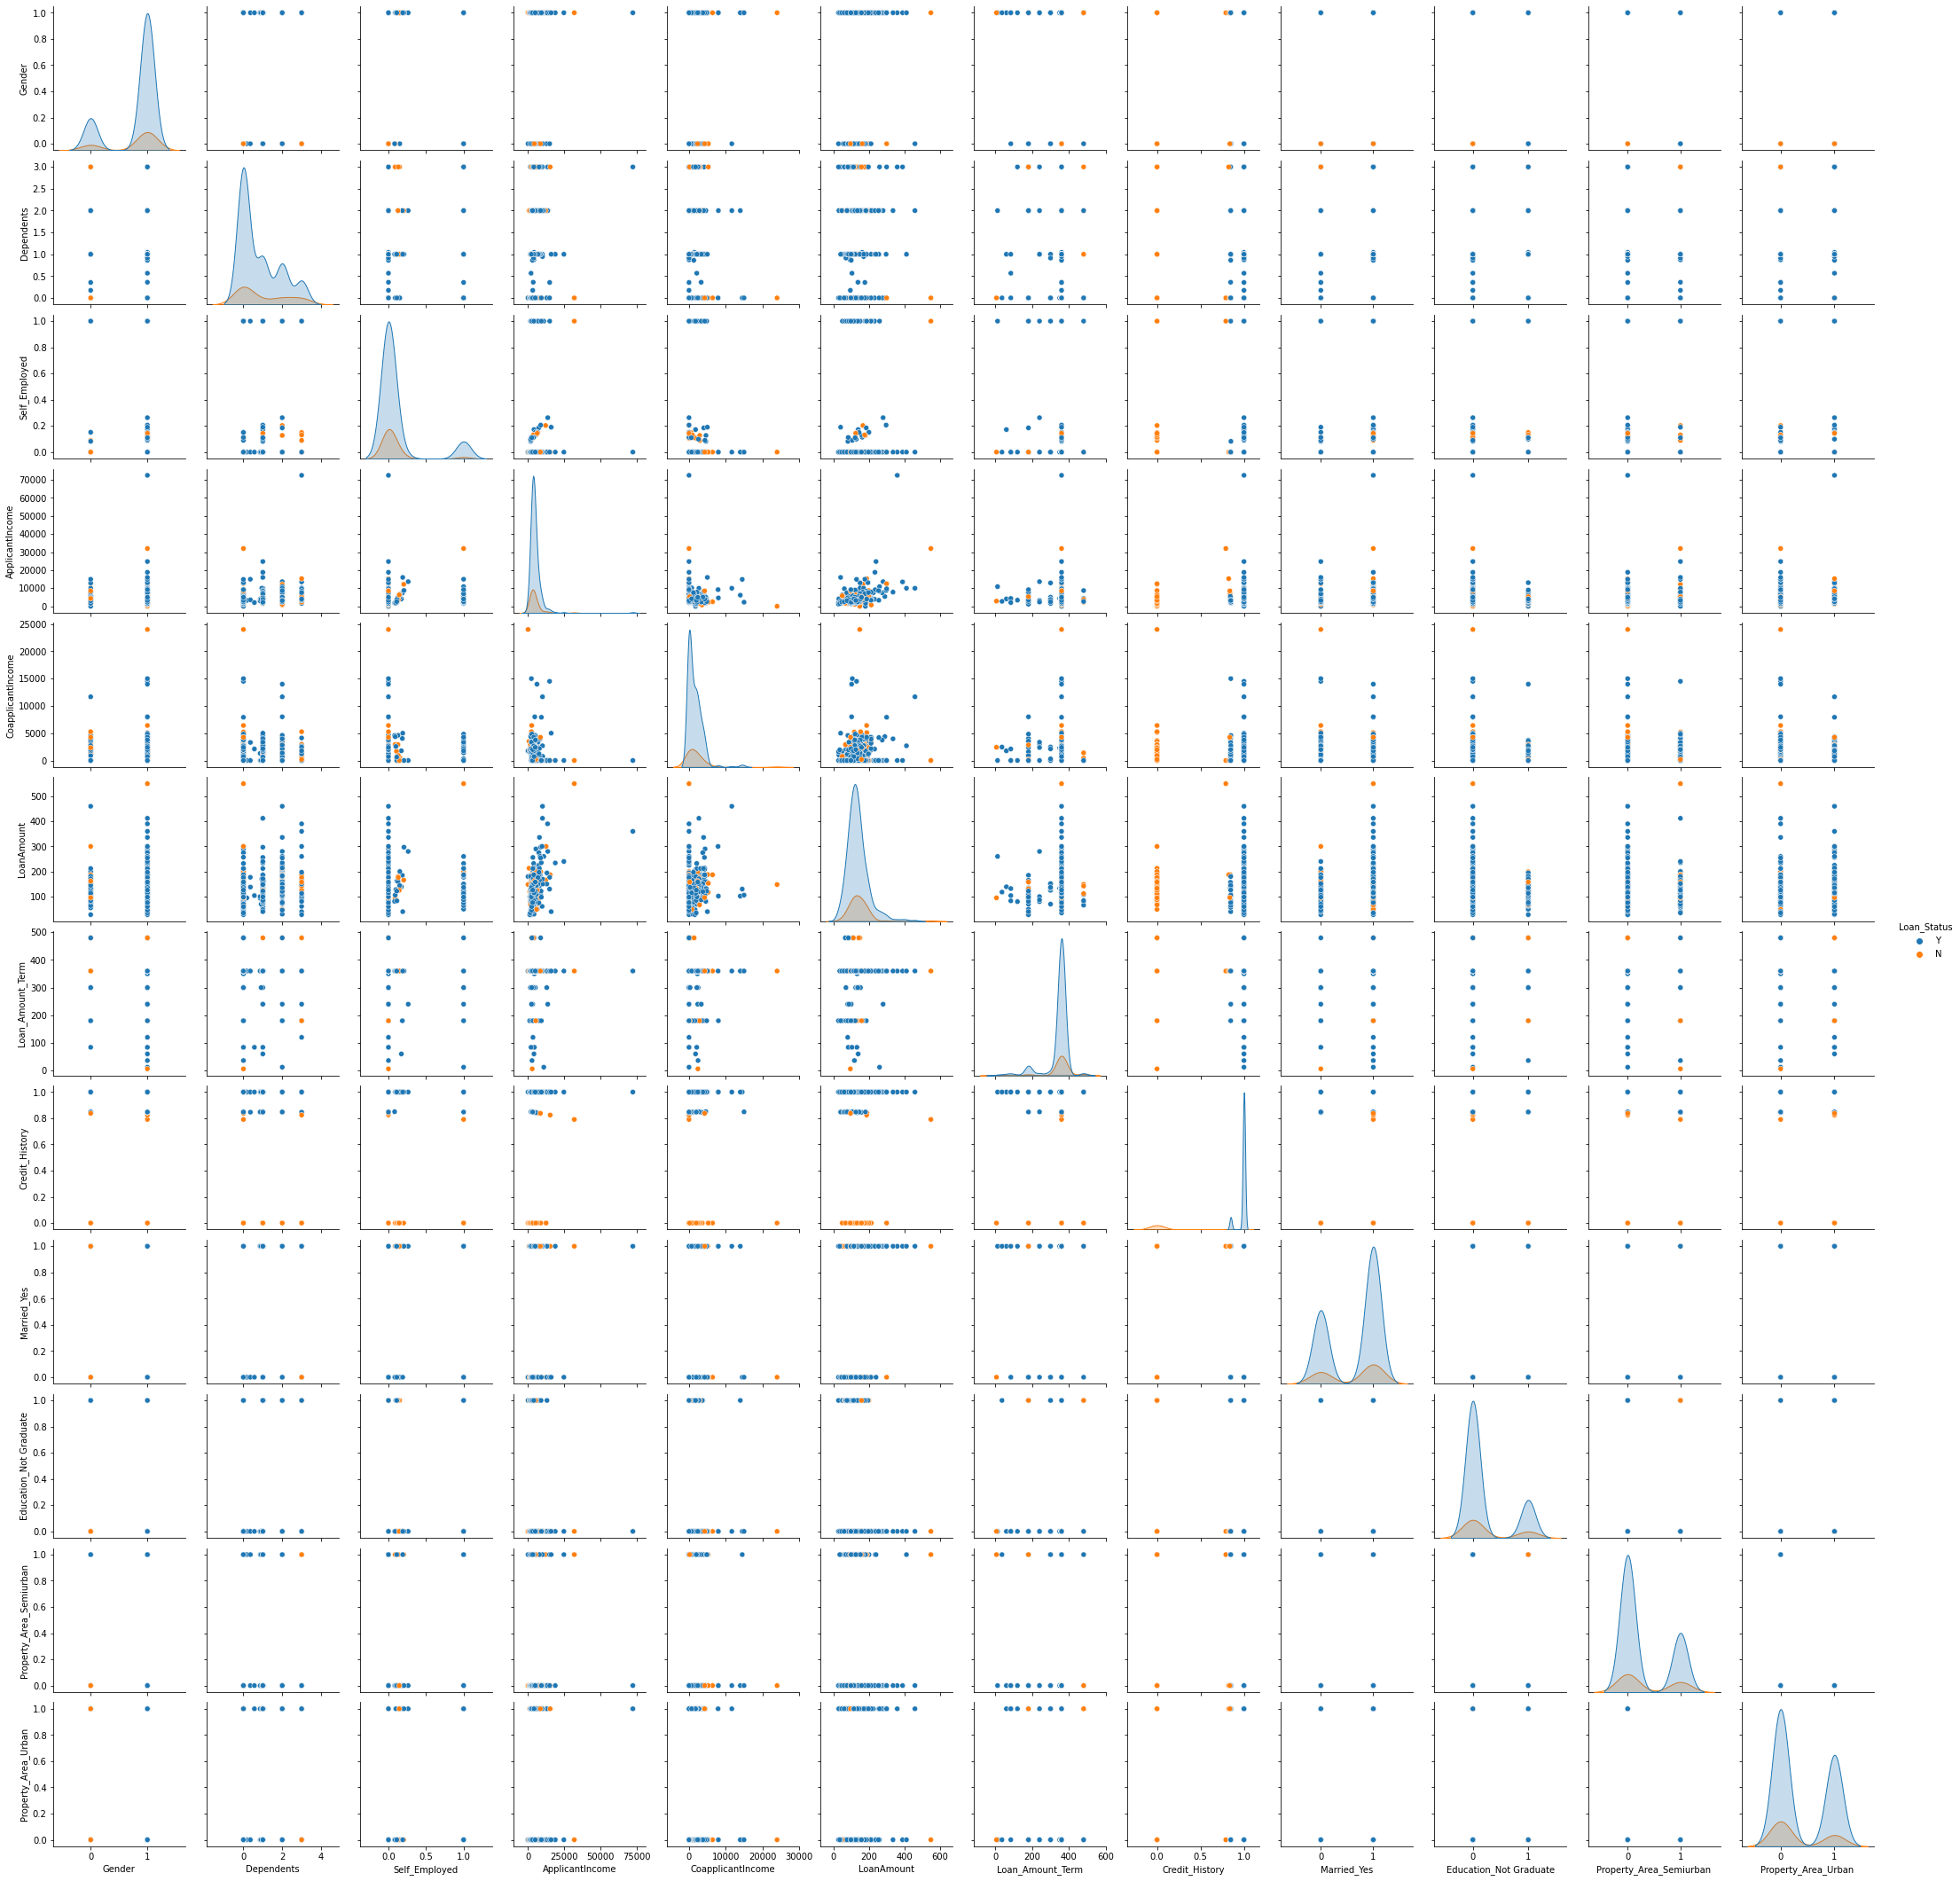

In [24]:
sns.pairplot(test_data, hue="Loan_Status")
plt.show()

Er litt vansklig å bedømme utfra pairplottet hvilke feature som påvirker mest. Ser ut til at det er credit history som er mest discriminantiv. La oss titte næremere på korrelasjonen

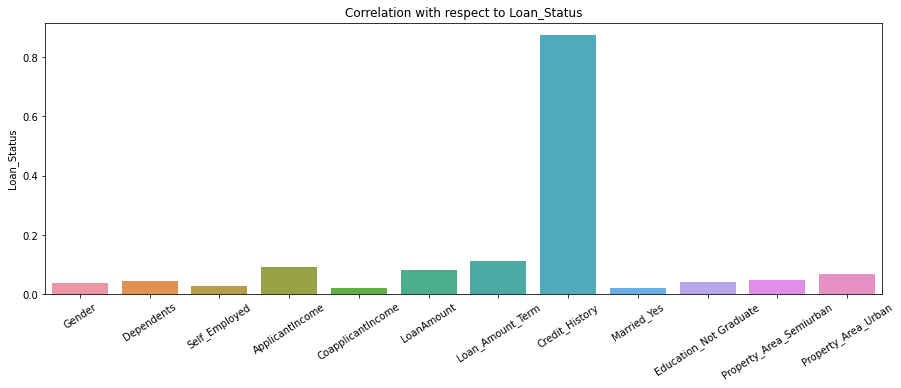

In [28]:
corr = test_data.corr(method="spearman")  # used spearman method to see if there were any non linear correlation
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x=corr["Loan_Status"].index[:-1], y=abs(corr["Loan_Status"][:-1]))
plt.xticks(rotation=33)
plt.title("Correlation with respect to Loan_Status")
plt.savefig("img/correlation_to_loan_status", bbox_inches="tight", pad_inches=0.2)
plt.show()

In [19]:
test_data[(test_data.Credit_History < 1) & (test_data.Credit_History > 0)].Loan_Status.value_counts()

1    25
0     4
Name: Loan_Status, dtype: int64

In [22]:
test_data[(test_data.Credit_History == 1)].Loan_Status.value_counts()

1    270
Name: Loan_Status, dtype: int64

In [29]:
test_data[(test_data.Credit_History == 0)].Loan_Status.value_counts()

0    57
Name: Loan_Status, dtype: int64

Ser ut til at modellen vår utelokkende predikerer basert på om man har hatt credit history eller ikke...

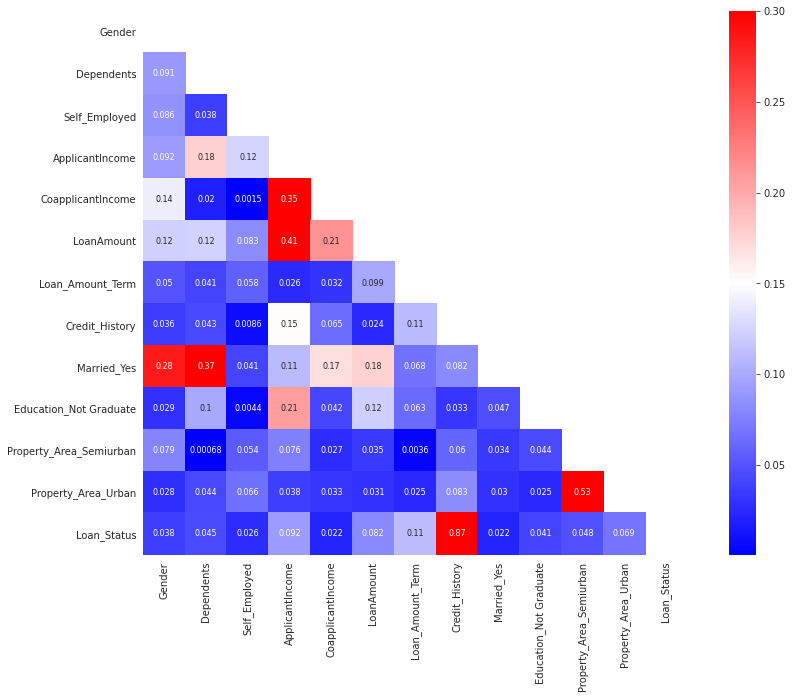

In [38]:
corr = abs(test_data.corr(method="spearman"))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 10))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True, ax=ax, cmap="bwr", annot_kws={"fontsize":8})

plt.show()

Korrelasjonene mellom dataene antyder at det er absolutt `credit_history` som bestemmer mest om en person får lån eller ikke. Nesten INGEN korrelasjon mellom noen av featursene bortsett fra `Loan_Amount_Term` og `Credit_History`, som er relativt vilt (ikke engang inntekt og inntekt har noe å si) 
#### La oss titte på om det er noen kjønnsforskjeller

In [30]:
test.Gender.value_counts()  # most men

Male      286
Female     70
Name: Gender, dtype: int64

In [31]:
test_data.Gender.value_counts() # 1 is male, 0 is female

1.0    286
0.0     70
Name: Gender, dtype: int64

In [32]:
male_loan_status = test_data[test_data.Gender == 1].Loan_Status.value_counts()

male_loan_status

1    239
0     47
Name: Loan_Status, dtype: int64

In [33]:
female_loan_status = test_data[test_data.Gender == 0].Loan_Status.value_counts()

female_loan_status

1    56
0    14
Name: Loan_Status, dtype: int64

First eye glance it seems like it is fearly equal (iow, the robot does not discrimanate based on Gender). Lets run a t-test

In [34]:
male_loan_status.index

Int64Index([1, 0], dtype='int64')

In [35]:
male_loan_status

1    239
0     47
Name: Loan_Status, dtype: int64

In [36]:
import scipy.stats as stats

male_pred = test_data[test_data.Gender == 1].Loan_Status
female_pred = test_data[test_data.Gender == 0].Loan_Status

mean_male = male_pred.mean()
std_male = male_pred.std()
obs_male = len(male_pred)

mean_female = female_pred.mean()
std_female = female_pred.std()
obs_female = len(female_pred)

diff = mean_male - mean_female

stats.t.cdf(x=diff, df=obs_male+obs_female-2, loc=std_male)

0.3686988042471321

In [37]:
sp = (((obs_male-1)*std_male**2+(obs_female-1)*std_female**2)/(obs_male+obs_female-2))**0.5
t_alpha = stats.t.ppf(0.975, obs_male+obs_female-2)

print(f'CI is [{round(diff-t_alpha*sp*(1/obs_male + 1/obs_female)**0.5,3), round(diff+t_alpha*sp*(1/obs_male + 1/obs_female)**0.5,3)}]')

CI is [(-0.063, 0.135)]


Som vi kan se både fra T-testen of konfidensintervallet så er vi godt innenfor. Det vil si at modellen ikke diskriminerer basert på kjønn.

#### Har det noe å si hvor man bor hen?

In [38]:
test

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
Loan_ID,,,,,,,,,,,
LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban
...,...,...,...,...,...,...,...,...,...,...,...
LP002971,Male,Yes,3+,Not Graduate,Yes,4009,1777,113.0,360.0,1.0,Urban
LP002975,Male,Yes,0,Graduate,No,4158,709,115.0,360.0,1.0,Urban
LP002980,Male,No,0,Graduate,No,3250,1993,126.0,360.0,NaN,Semiurban


In [164]:
semiurban_area = test_data[test_data.Property_Area_Semiurban == 1]

semiurban_area.Loan_Status.value_counts()

1    89
0    22
Name: Loan_Status, dtype: int64

In [163]:
urban_area = test_data[test_data.Property_Area_Urban == 1]

urban_area.Loan_Status.value_counts()

1    118
0     19
Name: Loan_Status, dtype: int64

In [174]:
rural_area =  test_data[(test_data.Property_Area_Urban == 0) & (test_data.Property_Area_Semiurban == 0)]

rural_area.Loan_Status.value_counts()

1    88
0    20
Name: Loan_Status, dtype: int64

Det ser ut til at de som bor i "Urbane_area" får litt oftere lån enn de andre. Men virker ikke som at dette er så veeeeldig signifikant ved første øyekast. (Skal sies at "urban_area" også har flere som søker lån også)

Kan hvertfall si at "rural_area" og "semiurban_area" er veldig like.

#### Se på hva man har å penger med å rutte med kontra om man får lån eller ikke